In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


In [3]:
data_path = "/kaggle/input/ventilator-pressure-prediction/train.csv"
#df = pd.read_csv(data_path , delimiter = ",")

dataset = pd.read_csv(data_path, index_col = 'id')

In [4]:
dataset.head()

,breath_id,R,C,time_step,u_in,u_out,pressure
id,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492
2,1,20,50,0.033652,18.383041,0,5.907794
3,1,20,50,0.067514,22.509278,0,7.876254
4,1,20,50,0.101542,22.808822,0,11.742872
5,1,20,50,0.135756,25.355850,0,12.234987


In [4]:
dataset.head(85)

,breath_id,R,C,time_step,u_in,u_out,pressure
id,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492
2,1,20,50,0.033652,18.383041,0,5.907794
3,1,20,50,0.067514,22.509278,0,7.876254
4,1,20,50,0.101542,22.808822,0,11.742872
5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...
81,2,20,20,0.000000,12.184338,0,6.048398
82,2,20,20,0.033998,13.980205,0,7.524743
83,2,20,20,0.068151,12.574163,0,9.282297


In [5]:
#Basic Stats

print("Dataset shape:", dataset.shape)
print("Unique breaths:", dataset['breath_id'].nunique())
print(dataset.describe())
print(dataset.dtypes)


Dataset shape: (6036000, 7)
Unique breaths: 75450
          breath_id             R             C     time_step          u_in  \
count  6.036000e+06  6.036000e+06  6.036000e+06  6.036000e+06  6.036000e+06   
mean   6.283886e+04  2.703618e+01  2.608072e+01  1.307225e+00  7.321615e+00   
std    3.633526e+04  1.959549e+01  1.715231e+01  7.659778e-01  1.343470e+01   
min    1.000000e+00  5.000000e+00  1.000000e+01  0.000000e+00  0.000000e+00   
25%    3.137700e+04  5.000000e+00  1.000000e+01  6.428995e-01  3.936623e-01   
50%    6.276550e+04  2.000000e+01  2.000000e+01  1.308123e+00  4.386146e+00   
75%    9.430100e+04  5.000000e+01  5.000000e+01  1.965502e+00  4.983895e+00   
max    1.257490e+05  5.000000e+01  5.000000e+01  2.937238e+00  1.000000e+02   

              u_out      pressure  
count  6.036000e+06  6.036000e+06  
mean   6.204493e-01  1.122041e+01  
std    4.852752e-01  8.109703e+00  
min    0.000000e+00 -1.895744e+00  
25%    0.000000e+00  6.329607e+00  
50%    1.000000e+00  7

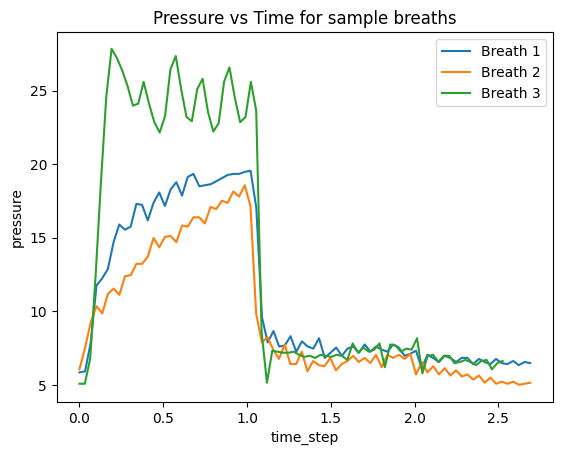

In [6]:
import matplotlib.pyplot as plt

def plot_breaths(dataset, n=3):
    unique_ids = dataset['breath_id'].unique()[:n]
    for b_id in unique_ids:
        breath = dataset[dataset['breath_id'] == b_id]
        plt.plot(breath['time_step'], breath['pressure'], label=f'Breath {b_id}')
    plt.xlabel('time_step')
    plt.ylabel('pressure')
    plt.title('Pressure vs Time for sample breaths')
    plt.legend()
    plt.show()

plot_breaths(dataset)


In [6]:
#Encodes categorical variables

import pandas as pd

def encode_features(df):
    df = df.copy()
    df = pd.get_dummies(df, columns=['R', 'C'], prefix=['R', 'C'])
    return df

dataset = encode_features(dataset)

In [7]:
dataset.head(30)

,breath_id,time_step,u_in,u_out,pressure,R_5,R_20,R_50,C_10,C_20,C_50
id,,,,,,,,,,,
1,1,0.000000,0.083334,0,5.837492,False,True,False,False,False,True
2,1,0.033652,18.383041,0,5.907794,False,True,False,False,False,True
3,1,0.067514,22.509278,0,7.876254,False,True,False,False,False,True
4,1,0.101542,22.808822,0,11.742872,False,True,False,False,False,True
5,1,0.135756,25.355850,0,12.234987,False,True,False,False,False,True
6,1,0.169698,27.259866,0,12.867706,False,True,False,False,False,True
7,1,0.203708,27.127486,0,14.695562,False,True,False,False,False,True
8,1,0.237723,26.807732,0,15.890699,False,True,False,False,False,True
9,1,0.271776,27.864715,0,15.539188,False,True,False,False,False,True


In [8]:
#Normalize u_in

#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


#scaler = StandardScaler()
scaler = MinMaxScaler()
dataset['u_in'] = scaler.fit_transform(dataset[['u_in']])

#dataset['time_step'] = dataset['time_step'] / dataset['time_step'].max()
dataset['time_step'] = scaler.fit_transform(dataset[['time_step']])


In [9]:
#Group Sequences per breath

import numpy as np

FEATURES = ['time_step', 'u_in', 'u_out', 'R_5', 'R_20', 'R_50', 'C_10', 'C_20', 'C_50']
TARGET = 'pressure'

def create_sequences_fast(df):
    grouped = df.groupby('breath_id')
    X = np.stack(grouped[FEATURES].apply(lambda x: x.to_numpy()).to_numpy())
    y = np.stack(grouped[TARGET].apply(lambda x: x.to_numpy()).to_numpy())
    return X.astype(np.float32), y.astype(np.float32)


X, y = create_sequences_fast(dataset)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (75450, 80, 9)
y shape: (75450, 80)


# Data class + DataLoader

In [10]:
#Create pttorch dataset class

import torch
from torch.utils.data import Dataset

class VentilatorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, 80, num_features)
        self.y = torch.tensor(y, dtype=torch.float32)  # (N, 80)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [11]:
#Data Loader

from torch.utils.data import DataLoader, random_split

# Split 90% train, 10% val
train_size = int(0.9 * len(X))
val_size = len(X) - train_size

train_dataset = VentilatorDataset(X[:train_size], y[:train_size])
val_dataset = VentilatorDataset(X[train_size:], y[train_size:])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)



# Define LSTM Model

In [12]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=0.1, bidirectional=False)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):  # x shape: (batch, seq_len, features)
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden)
        out = self.linear(lstm_out)  # (batch, seq_len, 1)
        return out.squeeze(-1)  # (batch, seq_len)


In [13]:
input_dim = X.shape[2]  # Number of input features
model = LSTMModel(input_dim=input_dim)

# Define GRU Model

In [14]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers,
                          batch_first=True, dropout=0.1, bidirectional=False)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):  # x: (batch, seq_len, input_dim)
        gru_out, _ = self.gru(x)  # (batch, seq_len, hidden_dim)
        out = self.linear(gru_out)  # (batch, seq_len, 1)
        return out.squeeze(-1)  # (batch, seq_len)


In [15]:
model = GRUModel(input_dim=X.shape[2])

# Define BiGRU Model

In [16]:
import torch.nn as nn
#    def __init__(self, input_dim, hidden_dim=128, num_layers=2):

class BiGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super(BiGRUModel, self).__init__()
        self.bigru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.1,
            bidirectional=True,
            batch_first=True
        )
        # Since it's bidirectional, hidden_dim * 2
        self.linear = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):  # x: (batch, seq_len, input_dim)
        out, _ = self.bigru(x)  # out: (batch, seq_len, hidden_dim*2)
        out = self.linear(out)  # (batch, seq_len, 1)
        return out.squeeze(-1)  # (batch, seq_len)


In [22]:
wandb.login()

# Initialize wandb
wandb.init(project="ventilator-pressure-prediction", name="bigru-pytorch", config={
    "epochs": 2,
    "batch_size": 32,
    "learning_rate": 1e-3,
    "hidden_dim": 128,
    "num_layers": 2
})
config = wandb.config

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [17]:
model = BiGRUModel(input_dim=X.shape[2])

# Define Transformer Model

In [18]:
import torch
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)

        self.pos_embedding = nn.Parameter(torch.randn(1, 80, model_dim))  # 80 = sequence length

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=256,
            dropout=dropout,
            batch_first=True  # Important!
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(model_dim, 1)

    def forward(self, x):  # x: (batch, seq_len, input_dim)
        x = self.input_proj(x) + self.pos_embedding[:, :x.size(1), :]  # (batch, seq_len, model_dim)
        x = self.transformer_encoder(x)  # (batch, seq_len, model_dim)
        x = self.output_layer(x)  # (batch, seq_len, 1)
        return x.squeeze(-1)  # (batch, seq_len)

# Updated Transformer with Dropout, LayerNorm, and Residuals

In [23]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, model_dim, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer_output):
        return self.norm(x + self.dropout(sublayer_output))


In [24]:
#self, input_dim, model_dim=128, num_heads=4, num_layers=2, dropout=0.1
class TimeSeriesTransformerWithRes(nn.Module):
    def __init__(self, input_dim, model_dim=128, num_heads=6, num_layers=9, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, 80, model_dim))  # Learnable positional embedding

        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=model_dim,
                nhead=num_heads,
                dim_feedforward=256,
                dropout=dropout,
                batch_first=True
            ) for _ in range(num_layers)
        ])

        self.residual_blocks = nn.ModuleList([
            ResidualBlock(model_dim, dropout=dropout) for _ in range(num_layers)
        ])

        self.final_norm = nn.LayerNorm(model_dim)
        self.output_layer = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.input_proj(x) + self.pos_embedding[:, :x.size(1), :]

        for encoder, residual in zip(self.encoder_layers, self.residual_blocks):
            sub_out = encoder(x)
            x = residual(x, sub_out)

        x = self.final_norm(x)
        x = self.output_layer(x)
        return x.squeeze(-1)


# Define CNN Model

In [25]:
import torch
import torch.nn as nn
#    def __init__(self, input_dim, hidden_dim=64, num_layers=4, dropout=0.2):

class CNNOnlyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=9, dropout=0.2):
        super(CNNOnlyModel, self).__init__()

        layers = []

        in_channels = input_dim
        out_channels = hidden_dim

        for i in range(num_layers):
            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm1d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

            in_channels = out_channels  # next layer's input

        self.cnn = nn.Sequential(*layers)
        self.fc = nn.Conv1d(out_channels, 1, kernel_size=1)  # final 1D conv for regression output

    def forward(self, x):
        # Input: (batch, seq_len, input_dim)
        x = x.permute(0, 2, 1)  # → (batch, input_dim, seq_len) for Conv1D
        x = self.cnn(x)         # → (batch, hidden_dim, seq_len)
        x = self.fc(x)          # → (batch, 1, seq_len)
        x = x.squeeze(1)        # → (batch, seq_len)
        return x


# Define TCN

In [26]:
import torch
import torch.nn as nn

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2  # maintain output size

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # 1x1 conv if input/output channels don't match
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.downsample(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        return x + residual  # Residual connection


In [27]:
class TCNModel(nn.Module):
    def __init__(self, input_dim, num_channels=[64, 64, 64], kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        in_channels = input_dim

        for i, out_channels in enumerate(num_channels):
            dilation = 2 ** i  # exponential dilation
            layers.append(
                ResidualBlock1D(in_channels, out_channels, kernel_size, dilation, dropout)
            )
            in_channels = out_channels

        self.network = nn.Sequential(*layers)
        self.final_conv = nn.Conv1d(in_channels, 1, kernel_size=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, channels, seq_len)
        x = self.network(x)
        x = self.final_conv(x)  # (batch, 1, seq_len)
        x = x.squeeze(1)        # (batch, seq_len)
        return x


# Model Training

In [28]:
model = BiGRUModel(input_dim=X.shape[2])

In [29]:
import torch.optim as optim
criterion = nn.MSELoss()
#criterion = nn.L1Loss()  # MAE
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [19]:
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, device='cuda'):
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)  # (batch, seq_len)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        # Log both train and val loss to wandb
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss
        })


        print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = BiGRUModel(input_dim=X.shape[2])
criterion = nn.MSELoss()
#model = LSTMModel(input_dim=X.shape[2]) 
#criterion = nn.L1Loss() original
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=40, device=device)

Epoch 1/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 92.15it/s]


Epoch 1/40 -> Train Loss: 14.85867 | Val Loss: 3.02251


Epoch 2/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 96.91it/s]


Epoch 2/40 -> Train Loss: 2.29386 | Val Loss: 2.03711


Epoch 3/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.64it/s]


Epoch 3/40 -> Train Loss: 1.59195 | Val Loss: 1.48281


Epoch 4/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.36it/s]


Epoch 4/40 -> Train Loss: 1.27772 | Val Loss: 1.20467


Epoch 5/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.75it/s]


Epoch 5/40 -> Train Loss: 1.11149 | Val Loss: 1.01961


Epoch 6/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.58it/s]


Epoch 6/40 -> Train Loss: 0.98621 | Val Loss: 0.87543


Epoch 7/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.01it/s]


Epoch 7/40 -> Train Loss: 0.86399 | Val Loss: 0.77508


Epoch 8/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 94.84it/s]


Epoch 8/40 -> Train Loss: 0.80450 | Val Loss: 0.74842


Epoch 9/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.63it/s]


Epoch 9/40 -> Train Loss: 0.70662 | Val Loss: 1.00272


Epoch 10/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.59it/s]


Epoch 10/40 -> Train Loss: 0.68693 | Val Loss: 0.57359


Epoch 11/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.65it/s]


Epoch 11/40 -> Train Loss: 0.61887 | Val Loss: 0.54360


Epoch 12/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.92it/s]


Epoch 12/40 -> Train Loss: 0.60890 | Val Loss: 0.84295


Epoch 13/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.82it/s]


Epoch 13/40 -> Train Loss: 0.62177 | Val Loss: 0.60756


Epoch 14/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.01it/s]


Epoch 14/40 -> Train Loss: 0.52693 | Val Loss: 0.55895


Epoch 15/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.27it/s]


Epoch 15/40 -> Train Loss: 0.48230 | Val Loss: 0.48894


Epoch 16/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.23it/s]


Epoch 16/40 -> Train Loss: 0.51547 | Val Loss: 0.54923


Epoch 17/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.33it/s]


Epoch 17/40 -> Train Loss: 0.46604 | Val Loss: 0.56030


Epoch 18/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 94.46it/s]


Epoch 18/40 -> Train Loss: 0.54053 | Val Loss: 0.47193


Epoch 19/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.24it/s]


Epoch 19/40 -> Train Loss: 0.43615 | Val Loss: 1.34488


Epoch 20/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.17it/s]


Epoch 20/40 -> Train Loss: 0.47009 | Val Loss: 0.40158


Epoch 21/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.52it/s]


Epoch 21/40 -> Train Loss: 0.42409 | Val Loss: 0.56299


Epoch 22/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.70it/s]


Epoch 22/40 -> Train Loss: 0.43997 | Val Loss: 0.50085


Epoch 23/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.42it/s]


Epoch 23/40 -> Train Loss: 0.40346 | Val Loss: 0.48698


Epoch 24/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.59it/s]


Epoch 24/40 -> Train Loss: 0.39317 | Val Loss: 0.37781


Epoch 25/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.40it/s]


Epoch 25/40 -> Train Loss: 0.38935 | Val Loss: 0.41082


Epoch 26/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.66it/s]


Epoch 26/40 -> Train Loss: 0.37864 | Val Loss: 0.40054


Epoch 27/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.56it/s]


Epoch 27/40 -> Train Loss: 0.36969 | Val Loss: 0.39807


Epoch 28/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.57it/s]


Epoch 28/40 -> Train Loss: 0.37650 | Val Loss: 0.37511


Epoch 29/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.37it/s]


Epoch 29/40 -> Train Loss: 0.43870 | Val Loss: 0.32440


Epoch 30/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.87it/s]


Epoch 30/40 -> Train Loss: 0.35397 | Val Loss: 0.39625


Epoch 31/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.79it/s]


Epoch 31/40 -> Train Loss: 0.34602 | Val Loss: 0.37890


Epoch 32/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.43it/s]


Epoch 32/40 -> Train Loss: 0.35158 | Val Loss: 0.46527


Epoch 33/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.41it/s]


Epoch 33/40 -> Train Loss: 0.34009 | Val Loss: 0.40372


Epoch 34/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.87it/s]


Epoch 34/40 -> Train Loss: 0.34929 | Val Loss: 0.44346


Epoch 35/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.61it/s]


Epoch 35/40 -> Train Loss: 0.33072 | Val Loss: 0.33774


Epoch 36/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.71it/s]


Epoch 36/40 -> Train Loss: 0.34194 | Val Loss: 0.35763


Epoch 37/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 95.71it/s]


Epoch 37/40 -> Train Loss: 0.31656 | Val Loss: 0.30647


Epoch 38/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 94.54it/s]


Epoch 38/40 -> Train Loss: 0.32462 | Val Loss: 0.33185


Epoch 39/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 94.66it/s]


Epoch 39/40 -> Train Loss: 0.32480 | Val Loss: 0.37391


Epoch 40/40 [Validation]: 100%|██████████| 118/118 [00:01<00:00, 94.95it/s]

Epoch 40/40 -> Train Loss: 0.31888 | Val Loss: 0.43272


# Testing Best Model On Test Dataset

In [39]:
test_data_path = "/kaggle/input/ventilator-pressure-prediction/test.csv"
#df = pd.read_csv(data_path , delimiter = ",")

test_df = pd.read_csv(test_data_path)
# Save id column before grouping
row_ids = test_df['id']

test_df.head()


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [40]:
# One-hot encode R and C
test_df = encode_features(test_df)  # same function as before

# Normalize u_in using train scaler
test_df['u_in'] = scaler.transform(test_df[['u_in']])

# (Optional but recommended) normalize time_step too if you did for train:
test_df['time_step'] = scaler.transform(test_df[['time_step']])


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- u_in
Feature names seen at fit time, yet now missing:
- time_step


In [ ]:
#Create sequences

def create_test_sequences(df):
    grouped = df.groupby('breath_id')
    X = np.stack(grouped[FEATURES].apply(lambda x: x.to_numpy()).to_numpy())
    return X.astype(np.float32)

X_test = create_test_sequences(test_df)


In [ ]:
class TestVentilatorDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]

test_dataset = TestVentilatorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model.eval()
model.to(device)

all_preds = []

with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        all_preds.append(outputs.cpu().numpy())

preds = np.concatenate(all_preds, axis=0)  # shape: (num_test_samples, 80)


In [ ]:
submission = pd.DataFrame({'id': row_ids, 'pressure': preds.flatten()})
submission.to_csv('submission.csv', index=False)

